# U-net Denoising demo

In [677]:
# libs
from scipy.io import wavfile
from scipy import signal
from time import time
from copy import deepcopy

import random
import librosa
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# reproducibility
seed = 7 # lucky number
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)
# this should take care of reproducibility in sklearn too
# (see https://sklearn-genetic-opt.readthedocs.io/en/stable/tutorials/reproducibility.html)

In [678]:
# check reproducibility (run these many times, after running all)
# if randomness is reproducible, the below code should give the same results every time
### Code
#print(get_random_noise_path(),shuffle([1,2,3,4,5], [-1,-2,-3,-4,-5], random_state = seed))
#tr,va,te = torch.utils.data.random_split(dataset,[.7,.15,.15],generator=gen)
#for (inpt,outpt) in make_batch(tr,32):
#  print(inpt,outpt)
#  break
### End Code
# reproducibility is the case for everything it seems (torch, python random, np random, sklearn)

## Steps
- 1. Load the data
- - Have the PASCAL clean data ready, and the ARCA23K synthetic data as well
- - Also load the HAN dataset from the Ali paper
- 2. Normalization steps for the data
- - Apply LPF/BPF and do resampling. All sounds should be at a standard frequency
- 3. Create the synthetic noise composites (and keep track of their noiseless counterparts)
- - Do visualizations (qualitative analysis here. You'll do this again at the end as PoC)
- 4. (Legacy) Run the STFT on both to create your inputs and outputs for the model
- 5. Segment the synthetic noise composites to create training and test data
- 6. Design the LU-Net
- 7. Train the LU-Net
- 8. Visualize results
- 9. Quantify the improvement in terms of SNR or similar
- - See if the LU-Net removes murmurs


In [679]:
## Dirs
# the circor digiscope phonocardiogram dataset
pcg_datapath = '/Users/donu/Desktop/S25/ELEC 594/datasets/the-circor-digiscope-phonocardiogram-dataset-1.0.3/'
# the bentley dataset is the clean PCG dataset from the U-net paper
pascal_dset_path = '/Users/donu/Desktop/S25/ELEC 594/datasets/pascal-dset/'

In [680]:
arcalabels_path = '/Users/donu/Desktop/S25/ELEC 594/datasets/ARCA23K_ground_truth/'
# the arcawavs directory contains the real world noise data from the ARCA23K dataset
arcawavs_path = '/Users/donu/Desktop/S25/ELEC 594/datasets/ARCA23K_audio/'
# hospital ambient sounds dataset, from the Ali paper
han_raw_path = '/Users/donu/Desktop/S25/ELEC 594/datasets/hospital-noise-original/'
han_filtered_path = '/Users/donu/Desktop/S25/ELEC 594/datasets/hospital-noise-filtered-resampled/'

In [681]:
# OAHS/physionet '16
physio16_path = '/Users/donu/Desktop/S25/ELEC 594/datasets/physio16/'
physio_anno_path = physio16_path +'annotations/Online_Appendix_training_set.csv'

## 1. Loading the data

### 1.a Exploring PCG data

In [682]:
# Exploring the PCG data
pcg_data = pd.read_csv(pcg_datapath+'training_data.csv')

In [683]:
pcg_data.shape

(942, 23)

In [684]:
pcg_data.columns

Index(['Patient ID', 'Recording locations:', 'Age', 'Sex', 'Height', 'Weight',
       'Pregnancy status', 'Murmur', 'Murmur locations',
       'Most audible location', 'Systolic murmur timing',
       'Systolic murmur shape', 'Systolic murmur grading',
       'Systolic murmur pitch', 'Systolic murmur quality',
       'Diastolic murmur timing', 'Diastolic murmur shape',
       'Diastolic murmur grading', 'Diastolic murmur pitch',
       'Diastolic murmur quality', 'Outcome', 'Campaign', 'Additional ID'],
      dtype='object')

In [685]:
pcg_data['Murmur'].value_counts()

Murmur
Absent     695
Present    179
Unknown     68
Name: count, dtype: int64

In [686]:
pcg_data.loc[pcg_data['Murmur'].eq('Absent') | pcg_data['Murmur'].eq('Present')]

,Patient ID,Recording locations:,Age,Sex,Height,Weight,Pregnancy status,Murmur,Murmur locations,Most audible location,...,Systolic murmur pitch,Systolic murmur quality,Diastolic murmur timing,Diastolic murmur shape,Diastolic murmur grading,Diastolic murmur pitch,Diastolic murmur quality,Outcome,Campaign,Additional ID
0,2530,AV+PV+TV+MV,Child,Female,98.0,15.9,False,Absent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
1,9979,AV+PV+TV+MV,Child,Female,103.0,13.1,False,Present,AV+MV+PV+TV,TV,...,High,Harsh,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
3,13918,AV+PV+TV+MV,Child,Male,98.0,15.9,False,Present,TV,TV,...,Low,Blowing,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
4,14241,AV+PV+TV+MV,Child,Male,87.0,11.2,False,Present,AV+MV+PV+TV,PV,...,Low,Harsh,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
5,14998,AV+PV+TV+MV,Child,Male,NaN,NaN,False,Absent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,85340,AV+PV+TV+MV,Child,Male,105.0,16.6,False,Absent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,CC2015,NaN
938,85341,AV+PV+TV+MV,Child,Male,92.0,15.2,False,Absent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,CC2015,NaN
939,85343,AV+PV+TV+MV,Child,Female,97.0,13.5,False,Present,MV+TV,TV,...,Low,Blowing,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
940,85345,AV+PV,Child,Female,132.0,38.1,False,Absent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,CC2015,NaN


### 1.b Loading the PASCAL dataset

In [687]:
pcg_data = pd.read_csv(pascal_dset_path+'set_b.csv')

In [688]:
pcg_data['label'].value_counts()

label
normal        320
murmur         95
extrastole     46
Name: count, dtype: int64

### 1.b.1 - Clean up horrible data formatting

In [689]:
#for i in range(pcg_data.shape[0]):
##  # delete "Btraining"
##  #pcg_data.loc[i,'fname'] = 'setb/'+pcg_data.iloc[i,:]['fname'].split('/')[-1][10:]
#  filename = pcg_data.iloc[i,:]['fname'].split('/')[-1]
#  cut_idx = re.search(r'\d',filename).start()
#  pcg_data.loc[i,'fname'] = pcg_data.loc[i,'fname'].replace('setb','set_b')
#  pcg_data.loc[i,'fname'] = 'set_b/'+filename[cut_idx:]
#  

In [690]:
#pcg_data.to_csv(pascal_dset_path+'set_b.csv',index=False)

In [691]:
pcg_data['sublabel'].value_counts()

sublabel
noisynormal    120
noisymurmur     29
Name: count, dtype: int64

In [692]:
pcg_data = pcg_data.loc[(pcg_data['label'].eq('normal') |
                        pcg_data['label'].eq('murmur')) & 
                        pcg_data['sublabel'].ne('noisynormal') & 
                        pcg_data['sublabel'].ne('noisymurmur')]

In [693]:
pcg_data

,dataset,fname,label,sublabel
46,b,set_b/112_1306243000964_A.wav,murmur,NaN
47,b,set_b/112_1306243000964_B.wav,murmur,NaN
48,b,set_b/112_1306243000964_D.wav,murmur,NaN
49,b,set_b/116_1306258689913_A.wav,murmur,NaN
50,b,set_b/116_1306258689913_C.wav,murmur,NaN
...,...,...,...,...
307,b,set_b/296_1311682952647_A1.wav,normal,NaN
308,b,set_b/296_1311682952647_A2.wav,normal,NaN
309,b,set_b/298_1311685888900_B.wav,normal,NaN
310,b,set_b/299_1311770522820_C.wav,normal,NaN


In [694]:
pcg_data.shape # this does not contain noisy data
# it does not contain murmurs either. this may be hugely importnat
# !IMPT: does not contain unlabelled data (which is like 1/3rd of dataset)

(266, 4)

In [695]:
# write to csv
##pcg_data.to_csv(bentley_dset+'set_b.csv',index=False)

In [696]:
#for fname in os.listdir(bentley_dset+'set_b/'):
#  # renaming
#  cutidx = re.search(r'\d',fname).start()
#  os.rename(bentley_dset+'set_b/'+fname,bentley_dset+'set_b/'+fname[cutidx:])

### 1.b.2 - Find Corresponding wav for each label

In [697]:
times = []
sample_rates = []
wav_lengths = dict()
for idx, row in pcg_data.iterrows():
  filepath_local = row['fname']
  label = row['label']
  #wavfile.read(pascal_dset_path+filepath_local)[1]
  arr,sr = librosa.load(pascal_dset_path+filepath_local)
  length = len(arr)/sr
  
  wav_lengths[filepath_local] = length
  times.append(length) #time
  sample_rates.append(sr)
  
print(np.mean(times),np.min(times),np.max(times))
print(np.mean(sample_rates),np.min(sample_rates),np.max(sample_rates))
times.sort()
PCG_SAMPLE_RATE = np.min(sample_rates) # everything is 22050
print(times[len(times)//5]) # ~20th percentile is 2.06 seconds

CUTOFF_SECONDS = 2
CUTOFF = CUTOFF_SECONDS*PCG_SAMPLE_RATE # 2 seconds
# ok, i think for now we can toss out times below 2 seconds

5.159780744377952 0.763265306122449 24.16
22050.0 22050 22050
2.0630385487528344


In [698]:
len(wav_lengths)

266

In [699]:
# checkpoint 1. done so far:
## downlaoded the datasets (synthetic noise, circor, and bentley - the U-net one)
## renamed the horribly named files and .csv column values in the bentley dataset
# able to read the corresponding wavfile for each row in the bentley dataset (i.e. map murmurs to wav!)

In [700]:
#next
## add noise to each, remove noise. see if that's possible
# ok, let's only resample ambient noise.

### 1.c - Loading the ARCA23K real world noises

In [701]:
#os.listdir(arcawavs)
noise_data = pd.read_csv(arcalabels_path+'train.csv')

In [702]:
label_amnts = dict(noise_data['label'].value_counts())

for key in label_amnts.keys():
  print(key,label_amnts[key])

Wind_instrument_and_woodwind_instrument 2458
Bowed_string_instrument 1841
Piano 677
Snare_drum 631
Trumpet 504
Fart 464
Electric_guitar 399
Acoustic_guitar 355
Bark 340
Coin_(dropping) 333
Female_speech_and_woman_speaking 313
Male_speech_and_man_speaking 302
Clapping 289
Gunshot_and_gunfire 283
Walk_and_footsteps 275
Organ 266
Bass_guitar 259
Camera 254
Squeak 253
Train 245
Zipper_(clothing) 244
Thump_and_thud 239
Livestock_and_farm_animals_and_working_animals 238
Whoosh_and_swoosh_and_swish 225
Tearing 214
Writing 211
Cough 208
Wind 206
Slam 201
Scratching_(performance_technique) 199
Rattle_(instrument) 196
Run 192
Dishes_and_pots_and_pans 191
Splash_and_splatter 186
Burping_and_eructation 181
Gong 175
Screaming 173
Crash_cymbal 171
Crackle 170
Crumpling_and_crinkling 165
Knock 150
Harp 149
Chewing_and_mastication 146
Stream 138
Tap 138
Toilet_flush 137
Keys_jangling 131
Meow 130
Waves_and_surf 126
Child_speech_and_kid_speaking 124
Boom 122
Drill 117
Cricket 115
Finger_snapping 110
Ha

In [703]:
# this is now legacy, since all non-relevant labels have been removed
relevant_labels = noise_data.loc[noise_data['label'].eq('Crumpling_and_crinkling') 
                                | noise_data['label'].eq('Child_speech_and_kid_speaking') 
                                | noise_data['label'].eq('Male_speech_and_man_speaking')
                                | noise_data['label'].eq('Female_speech_and_woman_speaking')
                                | noise_data['label'].eq('Cough')
                                | noise_data['label'].eq('Squeak')
                                | noise_data['label'].eq('Walk_and_footsteps')
                                | noise_data['label'].eq('Rattle')
                                | noise_data['label'].eq('Crack')]

important_wavs = set(relevant_labels['fname'].unique())
wav_to_type = dict(zip(relevant_labels['fname'],relevant_labels['label']))

In [704]:
# here is where audio files get selected and loaded in
# # start with the below noise sources # !impt

select_for = set(['Child_speech_and_kid_speaking','Crumpling_and_crinkling','Cough', 'Male_speech_and_man_speaking','Female_speech_and_woman_speaking','Squeak','Crack','Walk_and_footsteps','Rattle'])
list_of_wavs = [] # array of ints, since in the csv file, the wav files are named as numbers
for wavf in os.listdir(arcawavs_path):
  wavname = int(wavf.split('.')[0])
  if wav_to_type[wavname] in select_for:
    list_of_wavs.append(wavname)

In [705]:
len(list_of_wavs) # this isn't large because most of the ARCA23K dataset I deleted (it was huge)

494

In [706]:
## For removing irrelevant audio files. only need to run once

#for wavf in os.listdir(arcawavs):
#  wavname = wavf.split('.')[0]
#  if int(wavname) not in important_wavs:
#    os.remove(arcawavs+wavf)

In [707]:
def rescale_pcg(x):
  """
  normalize an ndarray x to [-1,1] based on largest abs value
  """
  return x/np.max(np.abs(x))

In [708]:
# now, load in the wavs
## resampling them to 4kHz since the clean PCG data is at 4kHz too
for wav_int in list_of_wavs[3:]:
  data, sr = librosa.load(arcawavs_path+str(wav_int)+'.wav',sr=None)
  print(np.max(data),np.min(data),np.mean(data))
  resampled = librosa.resample(data,orig_sr = sr,target_sr = 4000)
  resampled_zeromean = resampled - np.mean(resampled)
  normalized = rescale_pcg(resampled_zeromean)
  normalized = normalized - np.mean(normalized)
  break
  
  

0.48880005 -0.42004395 -4.2659335e-06


In [709]:
np.mean(normalized)

-1.4276852e-10

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        3.000e+00, 3.000e+00, 2.000e+00, 7.000e+00, 4.000e+00, 6.000e+00,
        7.000e+00, 9.000e+00, 1.600e+01, 1.900e+01, 4.000e+01, 5.200e+01,
        6.900e+01, 6.200e+01, 1.250e+02, 1.100e+02, 1.620e+02, 2.090e+02,
        2.710e+02, 5.490e+02, 5.883e+03, 4.810e+02, 2.440e+02, 1.980e+02,
        1.620e+02, 1.340e+02, 1.150e+02, 7.700e+01, 6.000e+01, 3.900e+01,
        3.300e+01, 2.700e+01, 1.900e+01, 1.200e+01, 1.100e+01, 2.000e+00,
        8.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([-1.        , -0.96219867, -0.92439735, -0.88659602, -0.8487947 ,
        -0.81099337, -0.77319205, -0.73539072, -0.6975894 , -0.65978807,
        -0.62198675, -0.58418542, -0.5463841 , -0.50858277, -0.47078148,
        -0.43298015, -0.39517882, -0.3573775 , -0.31957617, -0.28177485,
        -0.24397352, -0.2061722 , -0.16837087, -0.13056955, -0.09276822,
        -0.

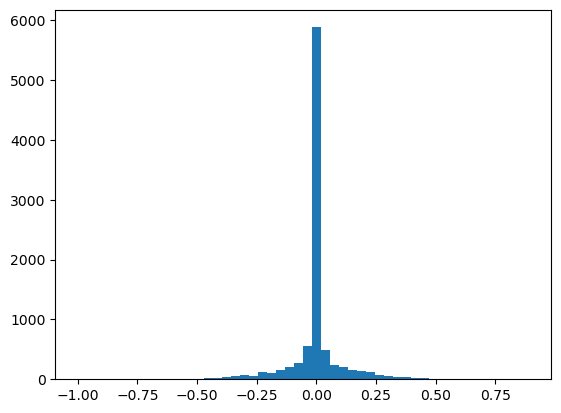

In [710]:
plt.hist(normalized,bins=50)

In [711]:
# i would expect the sound to have 0 mean? this is a Q for JoYo
# next step:
# # filter data? passband the PCG data to 1kHz and resample
# # add the noise to the PCG data (normalize noise first)
# # start to build classifier...
# # can create a stereo track and then combine it to mono?


### 2 - Normalization steps for the data

In [712]:
def lowpass_filter(signal_data, sampling_rate, cutoff_freq, order=4):
    nyquist = 0.5 * sampling_rate  # Nyquist frequency
    normal_cutoff = cutoff_freq / nyquist  # Normalize cutoff frequency
    
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    filtered_signal = signal.filtfilt(b, a, signal_data)
    
    return filtered_signal

In [713]:
def plot_fourier_spectrum(audio_signal, sample_rate,step_size=10,title='Fourier Spectrum Magnitude'):
    plt.clf()
    # Compute the FFT
    fft_values = np.fft.fft(audio_signal)
    magnitude = np.abs(fft_values)  # Get magnitude spectrum
    freq = np.fft.fftfreq(len(audio_signal), d=1/sample_rate)  # Frequency axis

    # Keep only the positive frequencies (since this is real valued data)
    half_idx = len(freq) // 2
    freq = freq[:half_idx:step_size] # adding these steps 
    magnitude = magnitude[:half_idx:step_size]

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(freq, magnitude)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.title(title)
    plt.grid()
    plt.show()

In [714]:
# huge Q at this point. What gets resampled to what frequency? 
# # i suppose we are strictly interested in low-ish frequency noise (everything else
# ... would get nuked. )

Original shape: (557918,), Filtered shape: (557918,), Resampled shape: (12652,)


<Figure size 640x480 with 0 Axes>

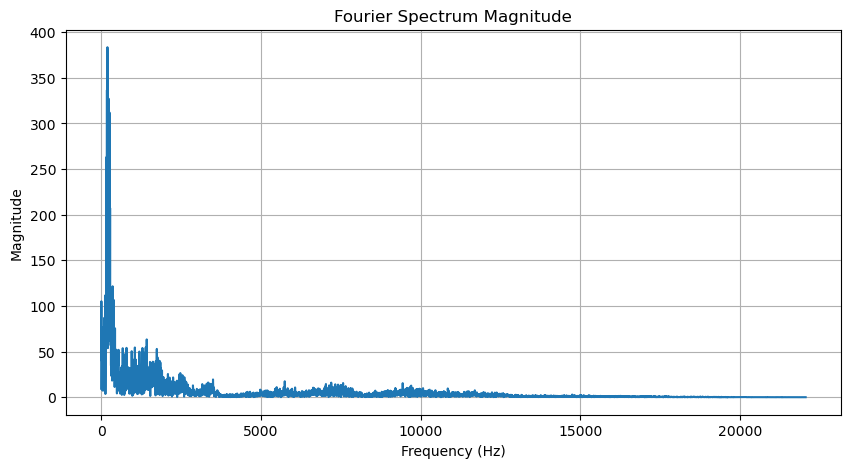

<Figure size 640x480 with 0 Axes>

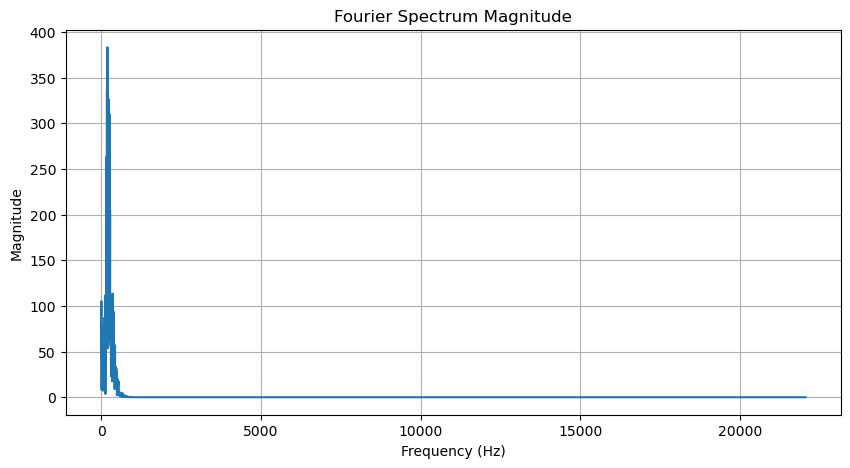

<Figure size 640x480 with 0 Axes>

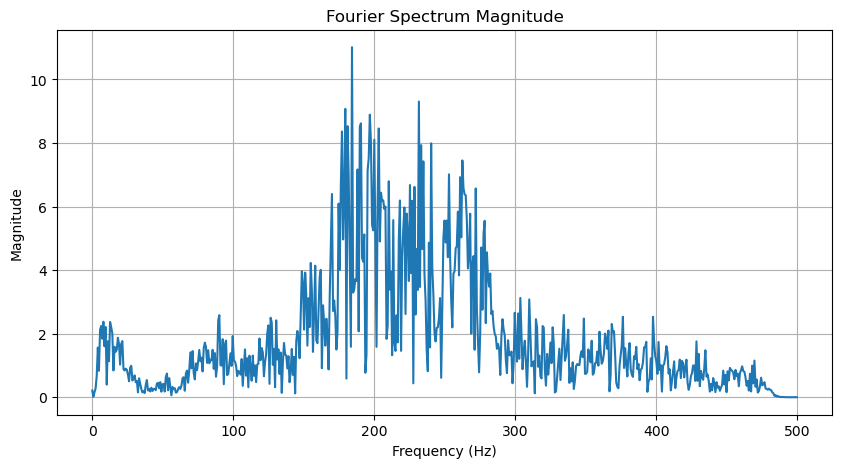

/Users/donu/Desktop/S25/ELEC 594/datasets/ARCA23K_audio/407722.wav


In [715]:
# Test 
cutoff_freq = 500
target_freq = cutoff_freq * 2

for wav in list_of_wavs:
    path_to_wav = arcawavs_path + str(wav) + '.wav'
    audiodata, sr = librosa.load(path_to_wav, sr=None)
    # Apply low-pass filter
    audio_data_new = lowpass_filter(audiodata, sr, cutoff_freq)

    # Resample the filtered signal
    new = librosa.resample(audio_data_new, orig_sr=sr, target_sr=target_freq)

    # Debugging info
    print(f"Original shape: {audiodata.shape}, Filtered shape: {audio_data_new.shape}, Resampled shape: {new.shape}")

    # Plot frequency content at each step
    plot_fourier_spectrum(audiodata, sr,step_size=50)  # Original
    plot_fourier_spectrum(audio_data_new, sr,step_size=50)  # After filtering
    plot_fourier_spectrum(new, target_freq,step_size=10)  # After resampling

    print(path_to_wav)
    break  # Stops after first file (as intended)


In [716]:
def load_from_filepath(filepath):
    """
    Load an audio file from a given file path and return the audio data and sample rate.
    """
    audio_data, sample_rate = librosa.load(filepath,sr=None)
    return audio_data, sample_rate

In [717]:
def downsample(audiodata, sr, target_freq):
  """
  Given a filepath for a wav, downsamples the audio to a target frequency
  (applies an LPF beforehand accordingly)
  """
  audio_data_new = lowpass_filter(audiodata, sr, target_freq//2)
  new = librosa.resample(audio_data_new, orig_sr=sr, target_sr=target_freq)
  return new

In [718]:
for wav in list_of_wavs:
  path_to_wav = arcawavs_path + str(wav) + '.wav'
  arca_data, arca_sr = load_from_filepath(path_to_wav)
  downsample(arca_data, arca_sr, 2000)

#### Comments
- I think a good enough idea is to LPF everything at 1kHz, then resample to 2kHz 

### 2.b - Examine Spectra of PCG Recordings

In [719]:
%%script false --no-raise-error 
# cell disabled (it served its purpose)
dsample_freq = 2000
fnames = pcg_data['fname'].tolist()
print(len(fnames))
for f_name in fnames[::-53]: # anything weird about the spectra?
  path_to_wav = pascal_dset_path + f_name
  pcg_recording, pcg_sr = load_from_filepath(path_to_wav)
  print(pcg_sr)
  #d_sampled = downsample(pcg_recording, pcg_sr, dsample_freq)
  plot_fourier_spectrum(pcg_recording,pcg_sr,step_size=50)
  #plot_fourier_spectrum(d_sampled, dsample_freq,step_size=50)  # Original

set_b/254_1309350589009_C.wav murmur
set_b/254_1309350589009_D.wav murmur
set_b/276_1311162716489_C.wav murmur


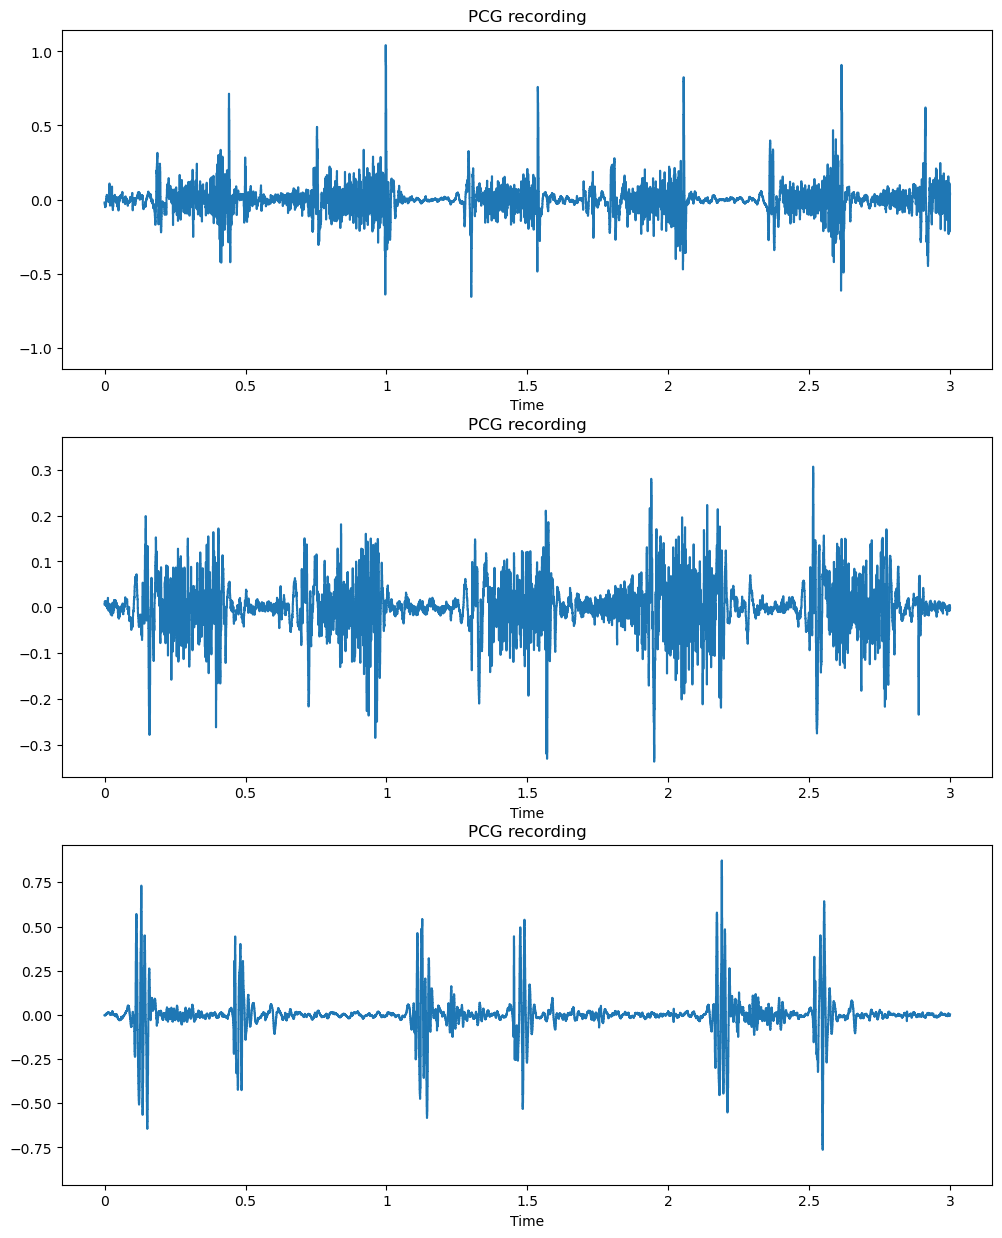

In [720]:
# examining the recordings in time as well

target_freq = 2000
num_to_show=3
startidx = 55

fig, ax = plt.subplots(nrows=num_to_show, figsize=(12, 5*num_to_show))
# want to show the same length for all of them actually. 3 seconds. 
good_idx = 0
for rowidx,row in pcg_data.iloc[startidx:,:].reset_index().iterrows():
  if num_to_show<=good_idx: 
    break
  
  # recording name and type
  fname = row['fname']
  fpath = pascal_dset_path+fname
  
  # load the data
  data, sr = load_from_filepath(fpath)
  length_of_rec = len(data)/sr
  # want to plot the same length for all recordings
  if length_of_rec<=3: 
    continue
  # good to plot
  print(fname, row['label'])
  #print(max(data))
  data = downsample(data,sr,target_freq) # downsampled data
  #print(max(data))
  ax[good_idx].set(title='PCG recording')
  #ax[1].set(title='PCG+Noise')
  librosa.display.waveshow(data[:target_freq*3],sr=target_freq,ax=ax[good_idx]) # original data
  good_idx+=1
  
# data either looks ok ish or horrible

## 3 - Add noise to the recordings

In [721]:
def get_random_noise_path():
  random_wav = random.choice(list_of_wavs)
  label = noise_data[noise_data['fname'] == random_wav]['label'].values[0]
  #print(f'ARCA23K file: {random_wav}. Noise Type: {label}') # obnoxious
  # !impt: there seems to be an enormous rate of mislabelling. terrible dset...
  return arcawavs_path + str(random_wav) + '.wav'

In [722]:
def get_n_random_noise_paths_arca(n):
  return [arcawavs_path + str(x) + '.wav' for x in random.sample(list_of_wavs, n)]

In [723]:
def get_n_random_noise_paths_han(n):
  return [han_raw_path + x for x in random.sample(os.listdir(han_raw_path), n)]

In [724]:
get_n_random_noise_paths_arca(5)

['/Users/donu/Desktop/S25/ELEC 594/datasets/ARCA23K_audio/256554.wav',
 '/Users/donu/Desktop/S25/ELEC 594/datasets/ARCA23K_audio/236597.wav',
 '/Users/donu/Desktop/S25/ELEC 594/datasets/ARCA23K_audio/508991.wav',
 '/Users/donu/Desktop/S25/ELEC 594/datasets/ARCA23K_audio/513685.wav',
 '/Users/donu/Desktop/S25/ELEC 594/datasets/ARCA23K_audio/447396.wav']

In [725]:
get_n_random_noise_paths_han(5)

['/Users/donu/Desktop/S25/ELEC 594/datasets/hospital-noise-original/seg_85.wav',
 '/Users/donu/Desktop/S25/ELEC 594/datasets/hospital-noise-original/seg_175.wav',
 '/Users/donu/Desktop/S25/ELEC 594/datasets/hospital-noise-original/seg_234.wav',
 '/Users/donu/Desktop/S25/ELEC 594/datasets/hospital-noise-original/seg_410.wav',
 '/Users/donu/Desktop/S25/ELEC 594/datasets/hospital-noise-original/seg_444.wav']

In [726]:
noise_data

,fname,label,mid
0,507,Acoustic_guitar,/m/042v_gx
1,251090,Acoustic_guitar,/m/042v_gx
2,161470,Acoustic_guitar,/m/042v_gx
3,18489,Acoustic_guitar,/m/042v_gx
4,251185,Acoustic_guitar,/m/042v_gx
...,...,...,...
17974,463104,Zipper_(clothing),/m/01s0vc
17975,575516,Zipper_(clothing),/m/01s0vc
17976,403656,Zipper_(clothing),/m/01s0vc
17977,562333,Zipper_(clothing),/m/01s0vc


In [727]:
get_random_noise_path() # this does get a random noise

'/Users/donu/Desktop/S25/ELEC 594/datasets/ARCA23K_audio/441938.wav'

In [728]:
def match_signal_and_noise_lengths(signal, noise):
  """
  Given a signal and noise, makes the noise the same length as signal
  through duplicating, then truncating
  - truncating the noise
  """
  signal_len = len(signal)
  noise_len = len(noise)
  
  if signal_len > noise_len:
    # Repeat the noise to match the signal length
    noise = np.tile(noise, signal_len // noise_len + 1)
  noise = noise[:signal_len]
  return noise

In [729]:
match_signal_and_noise_lengths(np.array([1,2,3,4,5,6,7]),np.array([1,2,3]))

array([1, 2, 3, 1, 2, 3, 1])

In [730]:
match_signal_and_noise_lengths(np.array([1,2]),np.array([3,2,1]))

array([3, 2])

In [731]:
def create_composite_at_snr(signal,noise,snr_db):
  """
  Function to combine two audio arrays, one signal one noise, at a given SNR
  
  SNR is in dB
  """
  signal_power = avg_power(signal**2)
  noise_power = avg_power(noise**2)
  if np.round(noise_power,3) == 0:
    print('Noise power is 0. Returning signal only')
    return signal
  ratio = np.sqrt((signal_power / noise_power) / (10 ** (snr_db / 10)))
  noise *= ratio
  return signal + noise

In [732]:
def create_composite(pcg_raw, pcg_sr, noise_raw, noise_sr, target_freq, snr):
  """
  A top-level function that combines the above functions to create a composite sound.
  
  Given a PCG filepath and a noise filepath, creates a composite sound by adding the two together.
  Both files are downsampled to the target frequency.
  
  
  Inputs:
  - pcg_filepath
  - noise_filepath
  - target_freq: the frequency to downsample the pcg data and noise data to
  - snr: desired SNR in dB of the combined sounds
  
  Returns the (downsampled) ground truth PCG data and the composite sound
  """
  pcg = downsample(pcg_raw, pcg_sr, target_freq) # downsample the PCG data
  pcg = rescale_pcg(pcg) # !impt: renormalize pcg data. resume work here
  noise = downsample(noise_raw, noise_sr, target_freq)
  noise = match_signal_and_noise_lengths(pcg, noise) # they are now the same size
  composite = create_composite_at_snr(pcg, noise, snr) # combine the two
  composite = rescale_pcg(composite) # normalize. I think this is good...
  
  return pcg, composite #composite

Noise power is 0. Returning signal only


<Figure size 640x480 with 0 Axes>

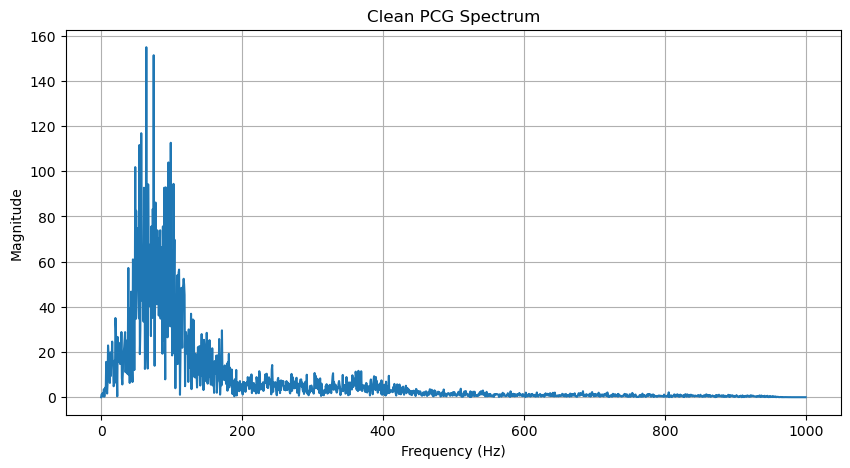

<Figure size 640x480 with 0 Axes>

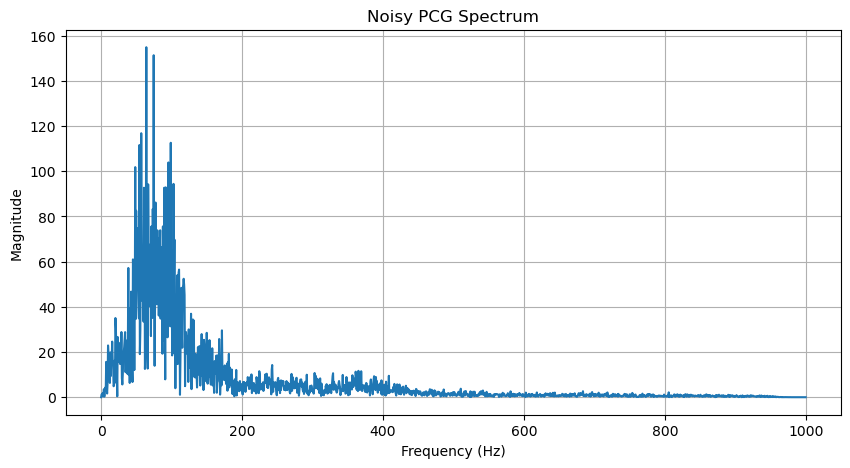

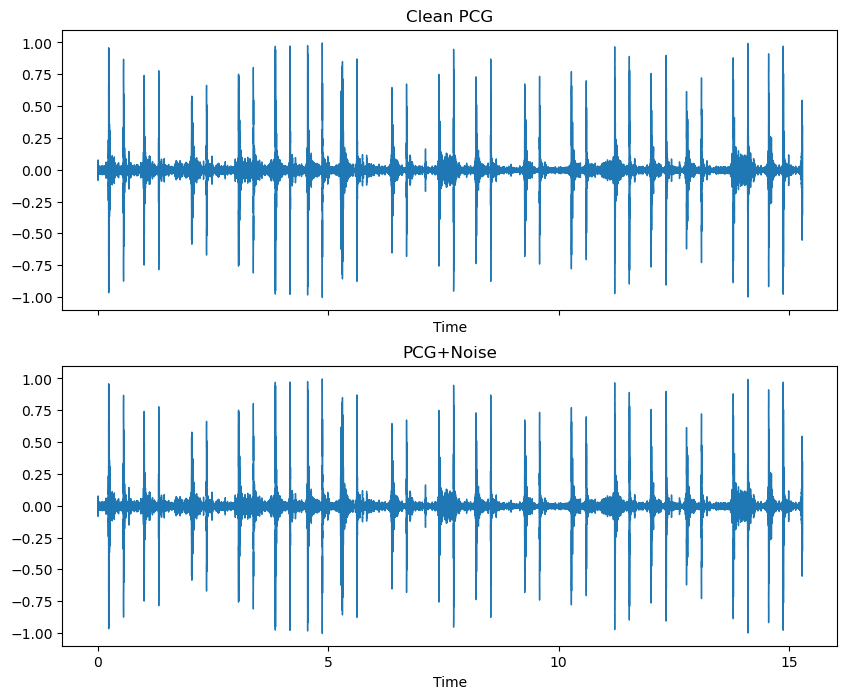

In [733]:
# proof of concept: see the spectrum of a clean PCG and a composite sound
target_freq = 2000 # downsample to this
snr_db = 3
for clean_pcg in pcg_data['fname'][2:]:
  if not clean_pcg.endswith('.wav'): # avoid .DS_Store among other things
    continue
  pcg_filepath = pascal_dset_path + clean_pcg
  random_noise = get_random_noise_path()
  
  pcg_raw, pcg_sr = load_from_filepath(pcg_filepath)
  #print(np.min(pcg_raw),np.max(pcg_raw)) # for seeing range
  noise_raw, noise_sr = load_from_filepath(random_noise)
  
  clean, composite = create_composite(pcg_raw, pcg_sr, noise_raw, noise_sr, target_freq,snr_db)
  # here is where el magico happenso. 
  # look at all the functions you wrote and find a use for them 
  # # e.g. downsample_from_filepath
  
  clean -= np.mean(clean) # DC components shouldn't be useful...?
  #print(np.min(clean),np.max(clean)) # for seeing range
  composite -= np.mean(composite)
  # now visualize. in frequency:
  plot_fourier_spectrum(clean,target_freq,step_size=10,title = 'Clean PCG Spectrum')
  plot_fourier_spectrum(composite,target_freq,step_size=10,title = 'Noisy PCG Spectrum')
  # in time
  fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(10, 8))
  ax[0].set(title='Clean PCG')
  ax[1].set(title='PCG+Noise')
  librosa.display.waveshow(clean,sr=target_freq,ax=ax[0])
  librosa.display.waveshow(composite,sr=target_freq,ax=ax[1])
  break

  


In [734]:
#!impt: so, there is often a huge DC component introduced. i am not sure why this is.
# perhaps the NN will learn to discard it, which would be fine. 
# but, it's also a pretty simple thing to discard

## 4 - Making the STFT features

In [735]:
from scipy.signal import ShortTimeFFT

In [736]:
#ShortTimeFFT()
nperseg = 1024
hann = signal.windows.hann(nperseg)

In [737]:
SFT = ShortTimeFFT(hann, hop=nperseg//4, fs = target_freq)

### 4.a - Creating Inputs and outputs for the model

In [738]:
unique_shapes, unique_shapes_2 = set(), set()

input_stft_data = []
output_stft_data = []

for pcg_local_path in pcg_data['fname']:
  if not pcg_local_path.endswith('.wav'): # avoid .DS_Store among other things
    continue
  if not wav_lengths[pcg_local_path] > CUTOFF_SECONDS:
    continue
  # here we have a problem with the function about "create composite from filepaths"
  pcg_filepath = pascal_dset_path + clean_pcg
  random_noise = get_random_noise_path()
  
  pcg_raw, pcg_sr = load_from_filepath(pcg_filepath)
  noise_raw, noise_sr = load_from_filepath(random_noise)
  pcg_raw = pcg_raw[:CUTOFF] # truncate the PCG data, to 2 seconds. 

  clean, composite = create_composite(pcg_raw, pcg_sr, noise_raw, noise_sr, target_freq,snr_db)
  clean -= np.mean(clean)
  composite -= np.mean(composite)

  # now, stft:
  stft_clean = SFT.stft(clean)
  unique_shapes.add(tuple(stft_clean.shape)) # everything is 513x18
  stft_noisy = SFT.stft(composite)
  unique_shapes_2.add(tuple(stft_noisy.shape)) # everything is 513x18
  
  input_stft_data.append(stft_noisy[2])
  output_stft_data.append(stft_clean[2])
#print(unique_shapes,unique_shapes_2)
# !impt: 151 sounds in total, of which 126 are unique. the most prevalent sound occurs 4 times.abs
# # (there is a bit of re-use overall)

Noise power is 0. Returning signal only
Noise power is 0. Returning signal only
Noise power is 0. Returning signal only
Noise power is 0. Returning signal only
Noise power is 0. Returning signal only
Noise power is 0. Returning signal only
Noise power is 0. Returning signal only
Noise power is 0. Returning signal only
Noise power is 0. Returning signal only
Noise power is 0. Returning signal only
Noise power is 0. Returning signal only
Noise power is 0. Returning signal only
Noise power is 0. Returning signal only
Noise power is 0. Returning signal only
Noise power is 0. Returning signal only
Noise power is 0. Returning signal only
Noise power is 0. Returning signal only
Noise power is 0. Returning signal only
Noise power is 0. Returning signal only
Noise power is 0. Returning signal only
Noise power is 0. Returning signal only
Noise power is 0. Returning signal only
Noise power is 0. Returning signal only
Noise power is 0. Returning signal only
Noise power is 0. Returning signal only


<Figure size 640x480 with 0 Axes>

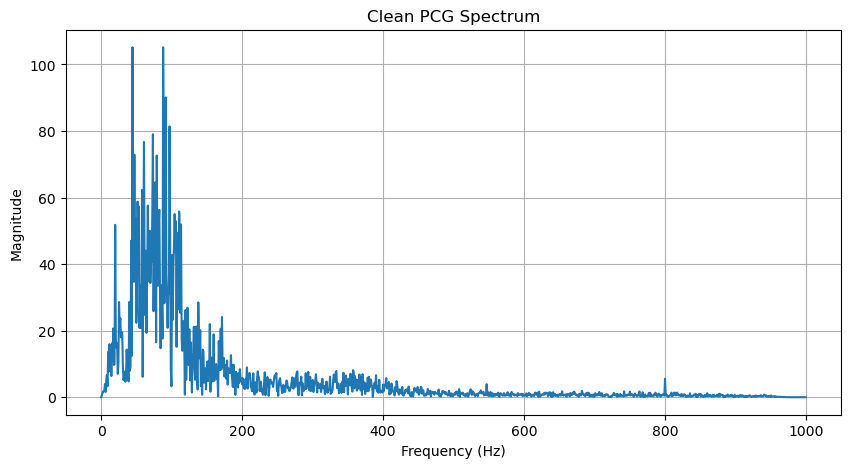

<Figure size 640x480 with 0 Axes>

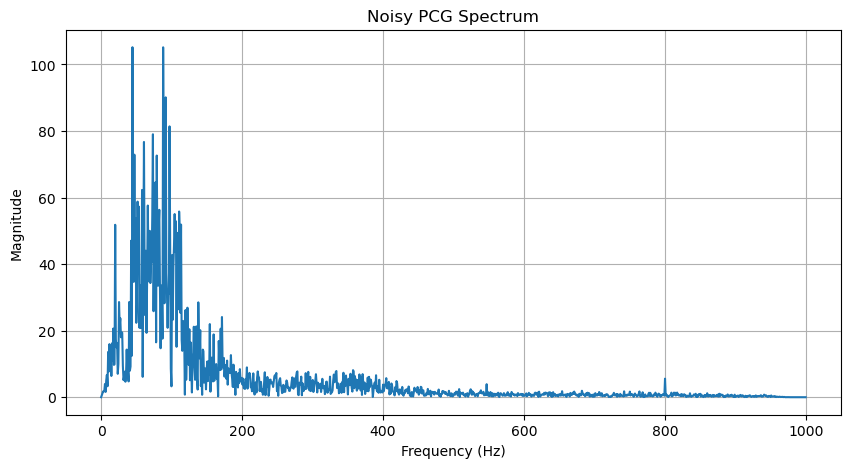

In [739]:
plot_fourier_spectrum(clean,target_freq,step_size=10,title = 'Clean PCG Spectrum')
plot_fourier_spectrum(composite,target_freq,step_size=10,title = 'Noisy PCG Spectrum')

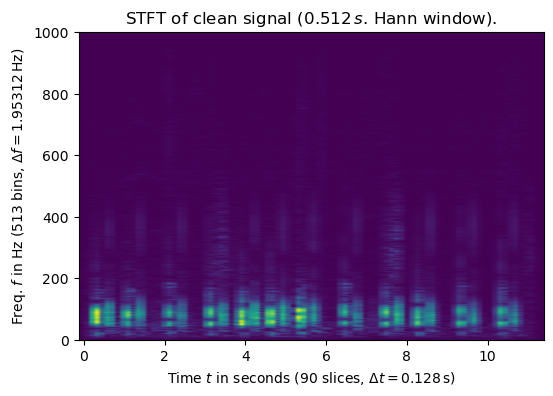

In [740]:
fig1, ax1 = plt.subplots(figsize=(6., 4.))
N = len(clean)
t_lo, t_hi = SFT.extent(N)[:2]
ax1.set_title(rf"STFT of clean signal ({SFT.m_num*SFT.T:g}$\,s$. Hann window).")
ax1.set(xlabel=f"Time $t$ in seconds ({SFT.p_num(N)} slices, " +
               rf"$\Delta t = {SFT.delta_t:g}\,$s)",
        ylabel=f"Freq. $f$ in Hz ({SFT.f_pts} bins, " +
               rf"$\Delta f = {SFT.delta_f:g}\,$Hz)",
        xlim=(t_lo, t_hi))

im1 = ax1.imshow(abs(stft_clean), origin='lower', aspect='auto',
                 extent=SFT.extent(N), cmap='viridis')

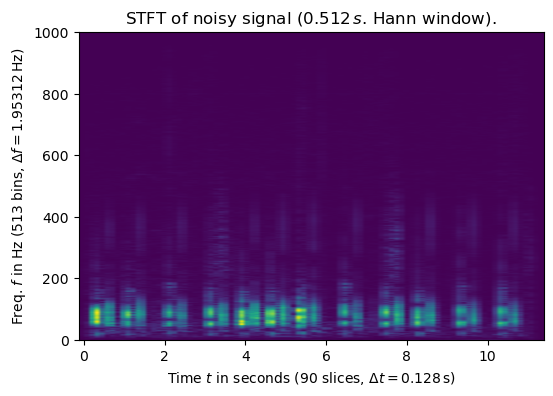

In [741]:
fig2, ax2 = plt.subplots(figsize=(6., 4.))
N = len(clean)
t_lo, t_hi = SFT.extent(N)[:2]
ax2.set_title(rf"STFT of noisy signal ({SFT.m_num*SFT.T:g}$\,s$. Hann window).")
ax2.set(xlabel=f"Time $t$ in seconds ({SFT.p_num(N)} slices, " +
               rf"$\Delta t = {SFT.delta_t:g}\,$s)",
        ylabel=f"Freq. $f$ in Hz ({SFT.f_pts} bins, " +
               rf"$\Delta f = {SFT.delta_f:g}\,$Hz)",
        xlim=(t_lo, t_hi))

im2 = ax2.imshow(abs(stft_noisy), origin='lower', aspect='auto',
                 extent=SFT.extent(N), cmap='viridis')

In [742]:
#stft_noisy # this is complex. should the real and imag parts be split?

In [743]:
# !impt: do i have enough data? So far, 200-some noisy samples...
# ways to get more data:
# # add multiple noise copies to each PCG sample

## 5 - Making Training and Test Data

### 5.a - Adding arbitrary noise 

In [744]:
# Some things to do:
# # From the ~250 clean recordings, add like 10 pairs of noise each
# # The noise can be from the ARCA23K dataset, but also the HAN dataset

In [745]:
len(pcg_data['fname'])*4*7

7448

In [746]:
from sklearn.utils import shuffle

#### 5.a.1 - Functions to combine clean PCGs with noises

In [747]:
def create_segments(signal_raw,signal_sr,a,b,snr_db,segment_length):
  """
  Very large function (too much?)
  
  Given a clean pcg (signal_raw) and its sample rate, and two ints x and y:
  1. Combines the clean PCG with x random noises from the HAN dataset and y random noises from the ARCA23K dataset
    a. Does so at each snr in snr_db
  2. Spits the data into segments that are segment_length long (in terms of indexes)
  """
  clean_pcgs = []
  noisy_pcgs = []
  for snr in snr_db:
    # get a random noises from the han dataset
    for noise_path in get_n_random_noise_paths_han(a):
      noise_raw, noise_sr = load_from_filepath(noise_path)
      clean, composite = create_composite(signal_raw, signal_sr, noise_raw, noise_sr, target_freq, snr)
      print(f"SNR_measured:{snr_calc(clean,composite)},SNR_Goal:{snr}")
      # really don't like this line jfc
      pairs[idx].append([idx_to_set[idx], clean_pcg, noise_path,snr])
      # cut each pair of recordings into fixed length subsections
      for i in range(0,len(clean)//segment_length):
        # segmentation
        clean_subsection = clean[i*segment_length:(i+1)*segment_length]
        composite_subsection = composite[i*segment_length:(i+1)*segment_length]
        # append
        clean_pcgs.append(clean_subsection)
        noisy_pcgs.append(composite_subsection)
        
    # get b random noises from the arca dataset
    for noise_path in get_n_random_noise_paths_arca(b):
      noise_raw, noise_sr = load_from_filepath(noise_path)
      composite,clean = create_composite(signal_raw, signal_sr, noise_raw, noise_sr, target_freq, snr)
      pairs[idx].append([idx_to_set[idx], clean_pcg, noise_path,snr])
      for i in range(0,len(clean)//segment_length):
        # segmentation
        clean_subsection = clean[i*segment_length:(i+1)*segment_length]
        composite_subsection = composite[i*segment_length:(i+1)*segment_length]
        # append
        noisy_pcgs.append(composite_subsection)
        clean_pcgs.append(clean_subsection)
  return clean_pcgs, noisy_pcgs

#### 5.a.2 - Code to generate synthetically noisy PCGs

In [748]:
gen = torch.Generator().manual_seed(seed) # this is new!

In [749]:
# do this to ensure that no PCG is in more than 1 of the train/test/val datasets
fnames_np = pcg_data['fname'].to_numpy()
training_list,val_list,test_list = torch.utils.data.random_split(fnames_np,[0.7,0.15,0.15],generator=gen)
inpt_data = [[],[],[]]
outpt_data = [[],[],[]]

In [750]:
pairs= [[],[],[]] # training, val, test
idx_to_set = ['training','val','test'] # feel like this is risky...
# !impt: format = (which_dset, pcg_path, noise_path, snr)

In [751]:
#%%script false --no-raise-error 
### ^ If un-commented, cell is disabled. (This cell is used for creating the dataset)
target_freq = 2000 # downsample to this
snr_db = [-3,0,3,6]
seconds_per_segment = 0.8
segment_length = int(target_freq*seconds_per_segment)
# determines dataset size
han_inputs, arca_inputs = 4, 3
# inputs and outputs for the model. Inputs are noisy, outputs are ground truth 
# takes a minute by the way
# it's often the case that noise has close to no power (this happens about 2.5% of the time) 
# # in this case, just set the inputs and outputs to be the same
# # the model should know it doesn't always have to denoise

# generate training data
for idx,dataset in enumerate([training_list,val_list,test_list]): # contains murmurs and normal PCG data
  for pcg_idx,clean_pcg in enumerate(dataset):
    if not clean_pcg.endswith('.wav'): # avoid .DS_Store among other things
      print('not a pcg')
      continue
    # load the signal from its filepath
    signal_filepath = pascal_dset_path + clean_pcg
    signal_raw, signal_sr = load_from_filepath(signal_filepath)
    # make the segments
    cleans, noisies = create_segments(signal_raw,signal_sr,han_inputs,arca_inputs,snr_db,segment_length)
    inpt_data[idx].extend(noisies)
    outpt_data[idx].extend(cleans)
# shuffle the data
training_ins, training_outs = shuffle(inpt_data[0],outpt_data[0], random_state = seed)
val_ins, val_outs = shuffle(inpt_data[1],outpt_data[1], random_state = seed)
test_ins, test_outs = shuffle(inpt_data[2],outpt_data[2], random_state = seed)

SNR_measured:-5.257383423189354,SNR_Goal:-3
SNR_measured:-3.6264028210919133,SNR_Goal:-3
Noise power is 0. Returning signal only
SNR_measured:inf,SNR_Goal:-3
SNR_measured:-1.6758224913697763,SNR_Goal:-3
Noise power is 0. Returning signal only
Noise power is 0. Returning signal only
SNR_measured:-3.537314196199663,SNR_Goal:0
Noise power is 0. Returning signal only
SNR_measured:inf,SNR_Goal:0
Noise power is 0. Returning signal only
SNR_measured:inf,SNR_Goal:0
Noise power is 0. Returning signal only
SNR_measured:inf,SNR_Goal:0
Noise power is 0. Returning signal only
Noise power is 0. Returning signal only
Noise power is 0. Returning signal only
SNR_measured:0.7075055610083445,SNR_Goal:3
Noise power is 0. Returning signal only
SNR_measured:inf,SNR_Goal:3
Noise power is 0. Returning signal only
SNR_measured:inf,SNR_Goal:3
Noise power is 0. Returning signal only
SNR_measured:inf,SNR_Goal:3
Noise power is 0. Returning signal only
Noise power is 0. Returning signal only
SNR_measured:0.20581026

/var/folders/c9/h_6qs3ld1mb00yp5yqn2w11c0000gn/T/ipykernel_8398/3472346521.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  return 10*np.log10(clean_power/noise_power)


Noise power is 0. Returning signal only
Noise power is 0. Returning signal only
SNR_measured:inf,SNR_Goal:-3
Noise power is 0. Returning signal only
SNR_measured:inf,SNR_Goal:-3
SNR_measured:-8.710721275064556,SNR_Goal:-3
Noise power is 0. Returning signal only
SNR_measured:inf,SNR_Goal:-3
Noise power is 0. Returning signal only
Noise power is 0. Returning signal only
Noise power is 0. Returning signal only
SNR_measured:inf,SNR_Goal:0
Noise power is 0. Returning signal only
SNR_measured:inf,SNR_Goal:0
Noise power is 0. Returning signal only
SNR_measured:inf,SNR_Goal:0
SNR_measured:-1.8353150081665384,SNR_Goal:0
Noise power is 0. Returning signal only
Noise power is 0. Returning signal only
Noise power is 0. Returning signal only
Noise power is 0. Returning signal only
SNR_measured:inf,SNR_Goal:3
SNR_measured:0.026172159754518698,SNR_Goal:3
Noise power is 0. Returning signal only
SNR_measured:inf,SNR_Goal:3
Noise power is 0. Returning signal only
SNR_measured:inf,SNR_Goal:3
Noise power 

In [752]:
len(pcg_data[pcg_data['label']=='murmur'])
#len(output_pcg_data)

66

In [753]:
pairs[0]

[['training',
  'set_b/128_1306344005749_D1.wav',
  '/Users/donu/Desktop/S25/ELEC 594/datasets/hospital-noise-original/seg_121.wav',
  -3],
 ['training',
  'set_b/128_1306344005749_D1.wav',
  '/Users/donu/Desktop/S25/ELEC 594/datasets/hospital-noise-original/seg_323.wav',
  -3],
 ['training',
  'set_b/128_1306344005749_D1.wav',
  '/Users/donu/Desktop/S25/ELEC 594/datasets/hospital-noise-original/seg_445.wav',
  -3],
 ['training',
  'set_b/128_1306344005749_D1.wav',
  '/Users/donu/Desktop/S25/ELEC 594/datasets/hospital-noise-original/seg_492.wav',
  -3],
 ['training',
  'set_b/128_1306344005749_D1.wav',
  '/Users/donu/Desktop/S25/ELEC 594/datasets/ARCA23K_audio/554230.wav',
  -3],
 ['training',
  'set_b/128_1306344005749_D1.wav',
  '/Users/donu/Desktop/S25/ELEC 594/datasets/ARCA23K_audio/524836.wav',
  -3],
 ['training',
  'set_b/128_1306344005749_D1.wav',
  '/Users/donu/Desktop/S25/ELEC 594/datasets/ARCA23K_audio/503893.wav',
  -3],
 ['training',
  'set_b/128_1306344005749_D1.wav',
  '

In [754]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

### 5.b - Saving and loading the data

In [ ]:
%%script false --no-raise-error 
### ^ If un-commented, cell is disabled. (This cell is used for saving the dataset)
trdata_loc = 'storage/training_inputs.npy'
vdata_loc = 'storage/val_inputs.npy'
tedata_loc = 'storage/test_inputs.npy'
np.save(trdata_loc, training_ins)
np.save(vdata_loc, val_ins)
np.save(tedata_loc, test_ins)
trdata_loc = 'storage/training_outputs.npy'
vdata_loc = 'storage/val_outputs.npy'
tedata_loc = 'storage/test_outputs.npy'
np.save(trdata_loc, training_outs)
np.save(vdata_loc, val_outs)
np.save(tedata_loc, test_outs)
print('Saved data to disk')

In [ ]:
train_inputs= np.load('storage/training_inputs.npy')
train_outputs= np.load('storage/training_outputs.npy')

val_inputs= np.load('storage/val_inputs.npy')
val_outputs= np.load('storage/val_outputs.npy')

test_inputs= np.load('storage/test_inputs.npy')
test_outputs= np.load('storage/test_outputs.npy')

In [ ]:
test_inputs.shape

(7196, 1600)

In [ ]:
shuffle([1,2,3,4,5,6],[1,2,3,4,5,6])

[[4, 6, 1, 3, 2, 5], [4, 6, 1, 3, 2, 5]]

In [ ]:
# 190/7448 = 2.55% of noise data had no power. 
# a lot of inputs to the model will be the same as the outputs
# this is good for robustness, i guess...
# there's this broad question of what inputs the model should be given
# ... i guess the answer is "everything: clean data, slightly noisy data, very noisy data"
# ... but check in with the team about this later

## 6 - U-Net Architecture

In [ ]:
if torch.cuda.is_available():
  device = 'cuda'
elif torch.mps.is_available():
  device = 'mps'
else:
  device = 'cpu'
print(f"Using {device} device")

Using mps device


### 6.a - Create Batches with DataLoader

In [ ]:
class PCG_Dataset(Dataset):
    def __init__(self, inputs, outputs):
        inputs = np.array(inputs) # inputs is expected to be a list of np vectors
        outputs = np.array(outputs) # outputs is expected to be a list of np vectors
        # making them an np.array speeds up the conversion process to tensor
        self.inputs = torch.tensor(inputs[:, np.newaxis, :], dtype=torch.float32).to(device)  # Ensure tensor format
        self.outputs = torch.tensor(outputs[:, np.newaxis, :], dtype=torch.float32).to(device)
        
    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]

In [ ]:
training_data_raw = PCG_Dataset(train_inputs,train_outputs) # i think that
val_data_raw = PCG_Dataset(val_inputs,val_outputs)
test_data_raw = PCG_Dataset(test_inputs,test_outputs)

In [ ]:
def make_batch(dataset,batchsize):
  """
  Creating batches
  """
  dataloader = DataLoader(
  	dataset,
    batch_size=batchsize, shuffle=True
)
  return dataloader

### 6.b - Design Model

In [ ]:
class LU_Net(nn.Module):
  def __init__(self,input_shape,output_shape):
    super().__init__()
    self.i_s = input_shape
    self.o_s = output_shape
    # model architecture
    # encoder, lvl 1
    self.conv_1 = nn.Conv1d(1,16,31,padding = 'same')
    self.relu_1 = nn.ReLU()
    
    # encoder, lvl 2
    self.conv_2 = nn.Conv1d(16,32,31,stride = 2,padding = 15)
    self.relu_2 = nn.ReLU()

    # encoder, lvl 3
    self.conv_3 = nn.Conv1d(32,32,31,stride = 2,padding = 15)
    self.relu_3 = nn.ReLU()

    # encoder, lvl 4
    self.conv_4 = nn.Conv1d(32,64,31,stride = 2,padding = 15)
    self.relu_4 = nn.ReLU()

    # encoder, lvl 5
    self.conv_5 = nn.Conv1d(64,64,31,stride = 2,padding = 15)
    self.relu_5 = nn.ReLU()

    # bottleneck
    self.bottleneck = nn.Conv1d(64,128,31,stride = 2,padding = 15)
    self.relu_bottleneck = nn.ReLU()
    # decoder, lvl 5
    self.conv_6 = nn.Conv1d(128,64,31,padding = 'same')
    self.relu_6 = nn.ReLU()
    self.upsample_1 = nn.Upsample(scale_factor = 2)
    # decoder, lvl 4
    self.conv_7 = nn.Conv1d(64,64,31,padding = 'same')
    self.relu_7 = nn.ReLU()
    self.upsample_2 = nn.Upsample(scale_factor = 2)
    # decoder, lvl 3
    self.conv_8 = nn.Conv1d(64,32,31,padding = 'same')
    self.relu_8 = nn.ReLU()
    self.upsample_3 = nn.Upsample(scale_factor = 2)
    # decoder, lvl 2
    self.conv_9 = nn.Conv1d(32,32,31,padding = 'same')
    self.relu_9 = nn.ReLU()
    self.upsample_4 = nn.Upsample(scale_factor = 2)
    # decoder, lvl 1
    self.conv_10 = nn.Conv1d(32,16,31,padding = 'same')
    self.relu_10 = nn.ReLU()
    self.upsample_5 = nn.Upsample(scale_factor = 2) 
    
    self.conv_final = nn.Conv1d(16,1,31,padding = 'same')
    self.tanh_final = nn.Tanh() # makes sense, since input is in [-1,1]
    
  # possible improvements: batch norm, gelu
  def forward(self,x): # i believe there is no activation function between lstm cells
    res = self.conv_1(x)
    res = self.relu_1(res)

    res = self.conv_2(res)
    res = self.relu_2(res)

    res = self.conv_3(res)
    res = self.relu_3(res)

    res = self.conv_4(res)
    res = self.relu_4(res)

    res = self.conv_5(res)
    res = self.relu_5(res)
   
    res = self.bottleneck(res)
    res = self.relu_bottleneck(res)
    
    res = self.conv_6(res)
    res = self.relu_6(res)
    res = self.upsample_1(res)
    
    res = self.conv_7(res)
    res = self.relu_7(res) 
    res = self.upsample_2(res)

    res = self.conv_8(res)
    res = self.relu_8(res) # bruh
    res = self.upsample_3(res)
    
    res = self.conv_9(res)
    res = self.relu_9(res) 
    res = self.upsample_4(res)
    
    res = self.conv_10(res)
    res = self.relu_10(res)
    res = self.upsample_5(res)
    
    res = self.conv_final(res)
    res = self.tanh_final(res)
    
    return res

In [ ]:
in_shape = train_inputs[0].shape[0]
model = LU_Net(in_shape,in_shape).to(device)
lossfunc = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=2e-5)

## 7 - Train Model

### 7.a - Train/Validation/Test split

In [ ]:
batch_size = 32

train_data = make_batch(training_data_raw,batch_size) # shuffles them too
val_data = make_batch(val_data_raw,batch_size)
test_data = make_batch(test_data_raw,batch_size)

### 7.b - Training

In [ ]:
def validation_acc(model,val_data):
  model.eval()
  with torch.no_grad():
    total_loss = 0
    for i, (inputs, outputs) in enumerate(val_data):
      outputs_pred = model(inputs)
      loss = lossfunc(outputs_pred,outputs)
      total_loss += loss.item()
    return total_loss/(i+1)

In [ ]:
%%script false --no-raise-error 
### ^ If un-commented, cell is disabled. (This cell is used for training the model)
num_epochs = 30
ratio_cutoff = 0.85 # amount training loss can be less than val loss by
overfit_cutoff = 1.025 # amount val loss is allowed to increase by
#
starttime = time()
# where training and val losses are stored (used later for plotting)
training_losses = []
validation_losses = []
# lowest encountered val loss
min_val = float("inf")
# training loop
for epoch in range(num_epochs):
  # reset loss per epoch
  running_loss = 0

  for idx, (inputs, labels) in enumerate(train_data):
    
    # Reset gradients per batch
    optimizer.zero_grad()

    # Predict
    outputs = model(inputs)

    # Compute the loss and its gradients
    loss = lossfunc(outputs, labels)
    loss.backward()

    # Adjust learning weights
    optimizer.step()

    # Gather data and report
    running_loss += loss.item()
  
  # keep track of training loss
  loss_this_epoch = running_loss/(idx+1)
  training_losses.append(loss_this_epoch)
  # keep track of val loss
  val_loss_this_epoch = validation_acc(model,val_data)
  validation_losses.append(val_loss_this_epoch)
  
  
  # the losses are averages by the way
  print(f' Epoch: {epoch} | Training Loss: {np.round(loss_this_epoch,5)} | Validation Loss: {np.round(val_loss_this_epoch,5)} ')
  # store the parameters of the model with the lowest validation loss
  if val_loss_this_epoch <min_val:
    best_model_state = deepcopy(model.state_dict()) # not sure if deepcopy does anything. but for safety
    optim_state = deepcopy(optimizer.state_dict())
  # check for indirect overfitting
  if loss_this_epoch<ratio_cutoff*val_loss_this_epoch:
    print(f"Training loss is less than {int(100*ratio_cutoff)}% of validation loss. Exiting!")
    break
  # check for direct overfitting
  if val_loss_this_epoch>overfit_cutoff*min_val:
    print(f"Validation loss is more than {int(100*(overfit_cutoff-1))}% of its minimum. Exiting to avoid overfitting")
    break
  if epoch == num_epochs-1:
    print(f"Reached epoch limit. Exiting")
    break
  # store minimum validation loss
  min_val = min(min_val,val_loss_this_epoch)

print(f"Model finished training. Total time: {int((time()-starttime)/60)}min {int(time()-starttime)%60}sec")

In [ ]:
# problem: training loss is completely flat
# - take notes about all these things in notion
# - note: these numbers are consistent with no training whatsoever
# things
# # 0. confirm that the inputs/outputs are actually correct (don't load them)
# # 1. might like to save the training and test data. also be sure that they're legit
# # 2. rewind this repo to the time where the loss was actually decreasing
# # 3. modify the learning rate
# # 4. try leaky relu or similar
# # 5. ask da homie for advice

# SOLN: the training rate was too high. oscillatory behavior then? idk.

### 7.c - Saving/Loading the model

In [ ]:
save_location = "storage/pseudo_unet.pth"

In [ ]:
%%script false --no-raise-error 
### ^ If un-commented, cell is disabled. (This cell is used for saving the model)
### (won't save the loss)
torch.save({'model':best_model_state,
            'optimizer':optim_state}, save_location)
print(f"Model saved to {save_location}")

In [ ]:
# loading the model
model_loaded = torch.load(save_location)
pseudo_unet = LU_Net(in_shape,in_shape).to(device)
pseudo_unet.load_state_dict(model_loaded['model'])
# Loading the optimizer
optimizer_loaded = torch.optim.Adam(model.parameters(),lr=2e-5)
optimizer_loaded.load_state_dict(model_loaded['optimizer'])

### 7.d - Visualizing model training

In [ ]:
%%script false --no-raise-error 
### Cell Disabled. (This cell is plotting the training process)
def plot_losses(training_losses,validation_losses):
  plt.plot(training_losses, label='Training Loss')
  plt.plot(validation_losses, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title("Training vs Validation Loss")
  plt.ylim([0,1.1*max(max(training_losses),max(validation_losses))])
  plt.legend()
  plt.show()

plot_losses(training_losses,validation_losses) # yikes!

## 8 - Measuring model performance

### 8.a - Metrics for model performance

In [ ]:
def avg_power(recording):
  """Calculates average power of a recording
  
  Input: A signal, e.g. PCG recording (np.array or similar)
  Output: power (float)
  """
  return np.mean(recording**2)

In [ ]:
def snr_calc(clean, noisy):
  """
  Calculate the SNR of a clean and noisy signal
  """
  clean_power = avg_power(clean)
  noise_signal = noisy - clean
  noise_power = avg_power(noise_signal)
  return 10*np.log10(clean_power/noise_power)

In [ ]:
def rmse(clean,noisy):
  """
  Calculate the root mean squared error between two signals
  """
  return avg_power(clean-noisy)**0.5

In [ ]:
avg_power(np.array([3,3,3,3,3,3]))

9.0

In [ ]:
rmse(np.array([1,2,3]),np.array([0,1,2]))

1.0

### 8.b - Testing model performance on test data

In [ ]:
# outline of what to do
# 1. iterate over the test data
# 2. run model on it (eval only)
# 3. generate RMSE/SNR metrics for the original clean/noisy pair
# 4. generate RMSE/SNR metrics for the original clean and denoised pair
# 5. store these somewhere for alter visualization

In [ ]:
# model performance on test data
orig_snrs = []
orig_rmses = []

denoised_snrs = []
denoised_rmses = []
# evaluate model on test data
with torch.no_grad():
  pseudo_unet.eval()
  for idx, (inputs, labels) in enumerate(test_data): # labels are slightly not properly normalized. what went wrong?
    outputs = pseudo_unet(inputs)
    # clean, noisy, and denoised
    noisy = inputs.cpu().detach().numpy()
    clean = labels.cpu().detach().numpy()
    denoised = outputs.cpu().detach().numpy() 
    # snr and rmse
    
    snr_noisy = snr_calc(clean,noisy)
    snr_denoised = snr_calc(clean,denoised)
    rmse_noisy = rmse(clean,noisy)
    rmse_denoised = rmse(clean,denoised)
    # add to arrays
    orig_snrs.append(snr_noisy)
    orig_rmses.append(rmse_noisy)
    denoised_snrs.append(snr_denoised)
    denoised_rmses.append(rmse_denoised)
    #print(f'Noisy SNR: {snr_noisy}, Denoised SNR: {snr_denoised}')
    #print(f'Noisy RMSE: {rmse_noisy}, Denoised RMSE: {rmse_denoised}')

In [ ]:
# very simple analysis
print(f"RMSE min/mean/max of noisy data: {np.min(orig_rmses):.3f},{np.mean(orig_rmses):.3f},{np.max(orig_rmses):.3f}")
print(f"RMSE min/mean/max of denoised data: {np.min(denoised_rmses):.3f},{np.mean(denoised_rmses):.3f},{np.max(denoised_rmses):.3f}")

RMSE min/mean/max of noisy data: 0.067,0.091,0.110
RMSE min/mean/max of denoised data: 0.053,0.074,0.108


In [ ]:
# very simple analysis
print(f"SNR min/mean/max of noisy data: {np.min(orig_snrs):.3f},{np.mean(orig_snrs):.3f},{np.max(orig_snrs):.3f}") # this really shouldn't be the case. what?
print(f"SNR min/mean/max of denoised data: {np.min(denoised_snrs):.3f},{np.mean(denoised_snrs):.3f},{np.max(denoised_snrs):.3f}")

SNR min/mean/max of noisy data: 0.540,2.404,4.290
SNR min/mean/max of denoised data: 2.459,4.265,5.777


In [ ]:
# Notes at this point:
# # Mean SNR should be ~1.5, since that is the avg of [-3,0,3,6], the reference SNR values. 
# # # The fact that this is not the case may suggest a bug in the creation of the synthetically noisy data
# # # (Double check )
# These results are basically very bad. Average RMSE is flat. SNR improvement is +0.3. Things to check:
# # 1. The data
# # # a. Visualize the "clean" pascal recordings. See what's up. 
# # # b. First, inspect the data qualitatively (listen to the combined sounds)
# # # c. Check if the SNR of the segments actually make sense

### 8.c - Test model performance on full pascal dataset

In [ ]:
full_pascal_performances = {'normal':{'orig_snr':[],'orig_rmse':[],'new_snr':[],'new_rmse':[]},
                            'murmur':{'orig_snr':[],'orig_rmse':[],'new_snr':[],'new_rmse':[]}}


### 8.d  - Visualizing model performance on PhysioNet '16

### 8.d.1 - Load the OAHS (Physionet '16) dataset

In [ ]:
# load dataset used in physionet '16
physio16_data  = pd.read_csv(physio_anno_path)

In [ ]:
# might use these again
normal_str = "Class (-1=normal 1=abnormal)"
murmur_str = "Murmurs (2=None 3=Weak 4=Strong 6=Unclear)"

In [ ]:
physio16_data.shape

(3153, 26)

In [ ]:
# the paths to each of the good normal PCG recordings. these were found in the other ipynb
normal_path_1 = physio16_path + 'training-a/a0045.wav'
normal_path_2 = physio16_path + 'training-a/a0027.wav'
normal_path_3 = physio16_path + 'training-a/a0127.wav'

# the paths to the good murmured heartbeat recordings.
murmur_path_1 = physio16_path + 'training-b/b0197.wav'
murmur_path_2 = physio16_path + 'training-b/b0030.wav'

In [ ]:
# load each of these recordings
normal_rec_1, sr_physio16 = load_from_filepath(normal_path_1) # the sr is the same for all recordings
normal_rec_2 = load_from_filepath(normal_path_2)[0]
normal_rec_3 = load_from_filepath(normal_path_3)[0]
# for murmurs too
murmur_rec_1 = load_from_filepath(murmur_path_1)[0]
murmur_rec_2 = load_from_filepath(murmur_path_2)[0]

[Text(0.5, 1.0, 'Murmur PCG 2 (b0030)')]

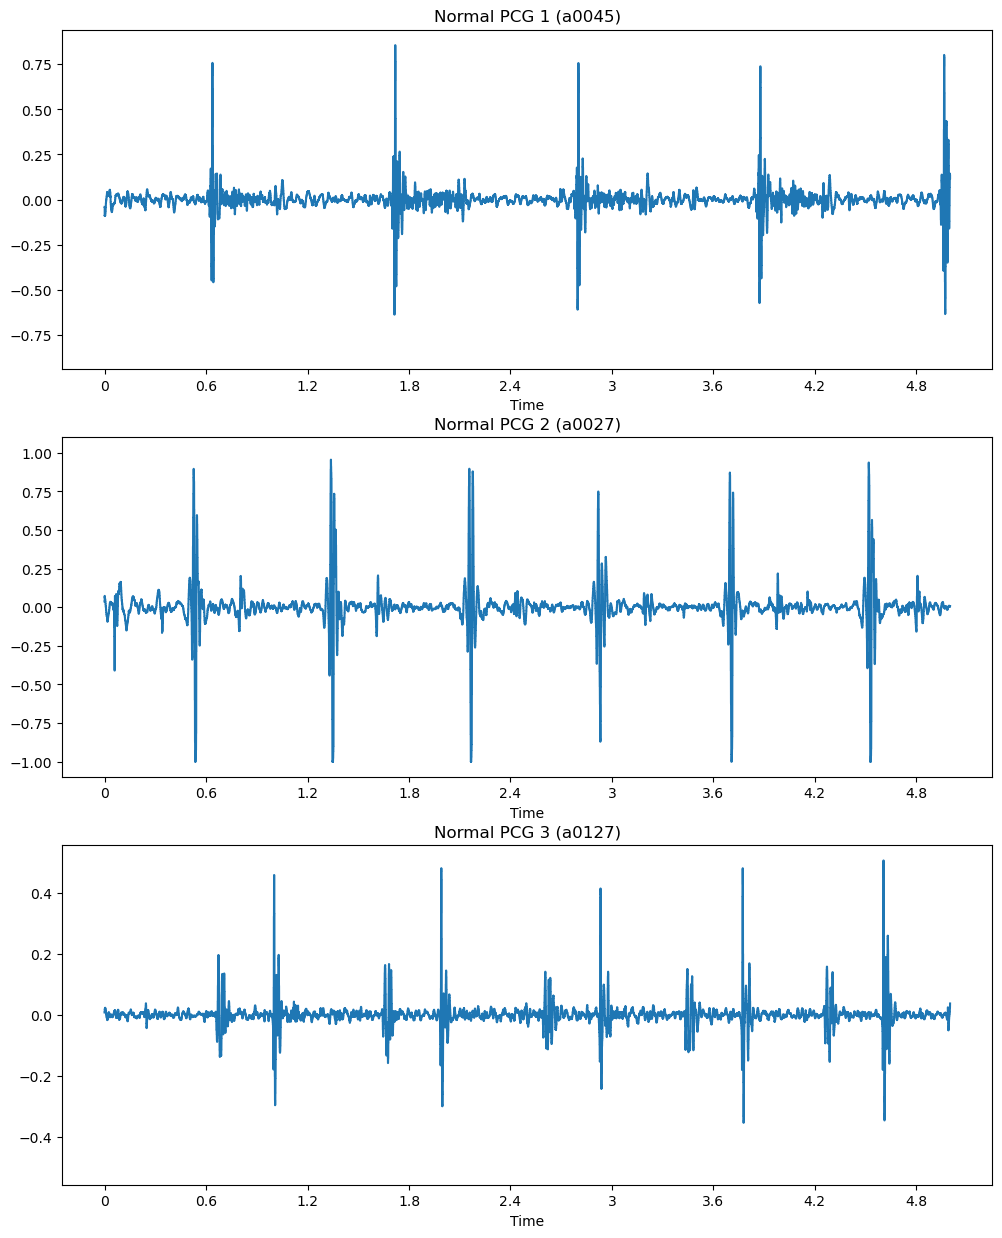

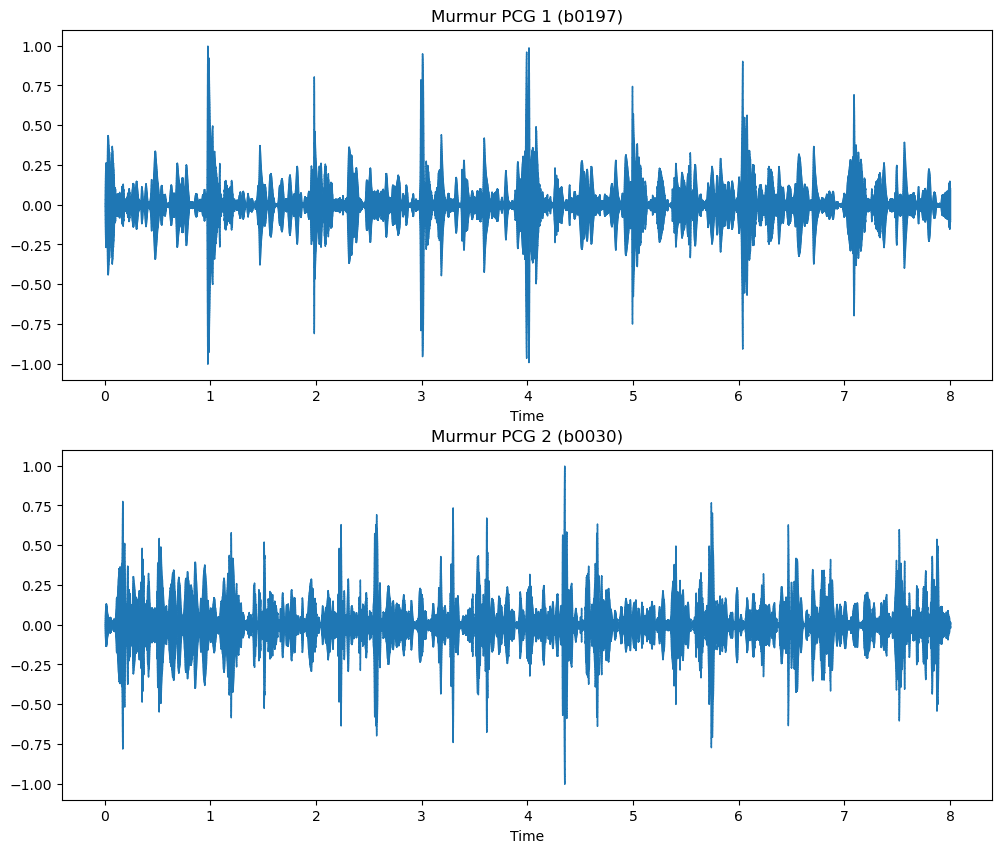

In [ ]:
# plot them
# no need to plot 30 seconds worth to be honest. reduce to 5-10 seconds
secs = 5

fig, ax = plt.subplots(nrows=3, figsize=(12, 5*3))
librosa.display.waveshow(normal_rec_1[:secs*sr_physio16],sr=sr_physio16,ax=ax[0])
ax[0].set(title='Normal PCG 1 (a0045)')
librosa.display.waveshow(normal_rec_2[:secs*sr_physio16],sr=sr_physio16,ax=ax[1])
ax[1].set(title='Normal PCG 2 (a0027)')
librosa.display.waveshow(normal_rec_3[:secs*sr_physio16],sr=sr_physio16,ax=ax[2])
ax[2].set(title='Normal PCG 3 (a0127)')
# now the murmurs
fig, ax = plt.subplots(nrows=2, figsize=(12, 5*2))
librosa.display.waveshow(murmur_rec_1,sr=sr_physio16,ax=ax[0])
ax[0].set(title='Murmur PCG 1 (b0197)')
librosa.display.waveshow(murmur_rec_2,sr=sr_physio16,ax=ax[1])
ax[1].set(title='Murmur PCG 2 (b0030)')

### 8.d.2 - Qualitative Observations on OAHS dataset

In [ ]:
joint_snr = 3
target_freq = sr_physio16 # 2khz btw

# arrays
regular_pcgs = [normal_rec_1, normal_rec_2, normal_rec_2, murmur_rec_1, murmur_rec_2]
noise_paths = get_n_random_noise_paths_han(5) # 5 real world hospital sounds

noisy_pcgs = []
for regular_pcg, noise in zip(regular_pcgs, noise_paths):
  noises, noise_sr = load_from_filepath(noise)
  # downsample to the same frequency
  noise = downsample(noise_raw, noise_sr, target_freq)
  # match lengths
  noise = match_signal_and_noise_lengths(regular_pcg, noise)
  
  composite = create_composite_at_snr(regular_pcg, noise, joint_snr) # combine the two
  composite = rescale_pcg(composite) # normalize to end
  
  # that's all
  noisy_pcgs.append(composite)

noisy_n1, noisy_n2, noisy_n3, noisy_m1, noisy_m2 = noisy_pcgs
# n1 = normal 1, m2 = murmur 2, etc

[Text(0.5, 1.0, 'Noisy n1 (a0045). SNR: 3dB')]

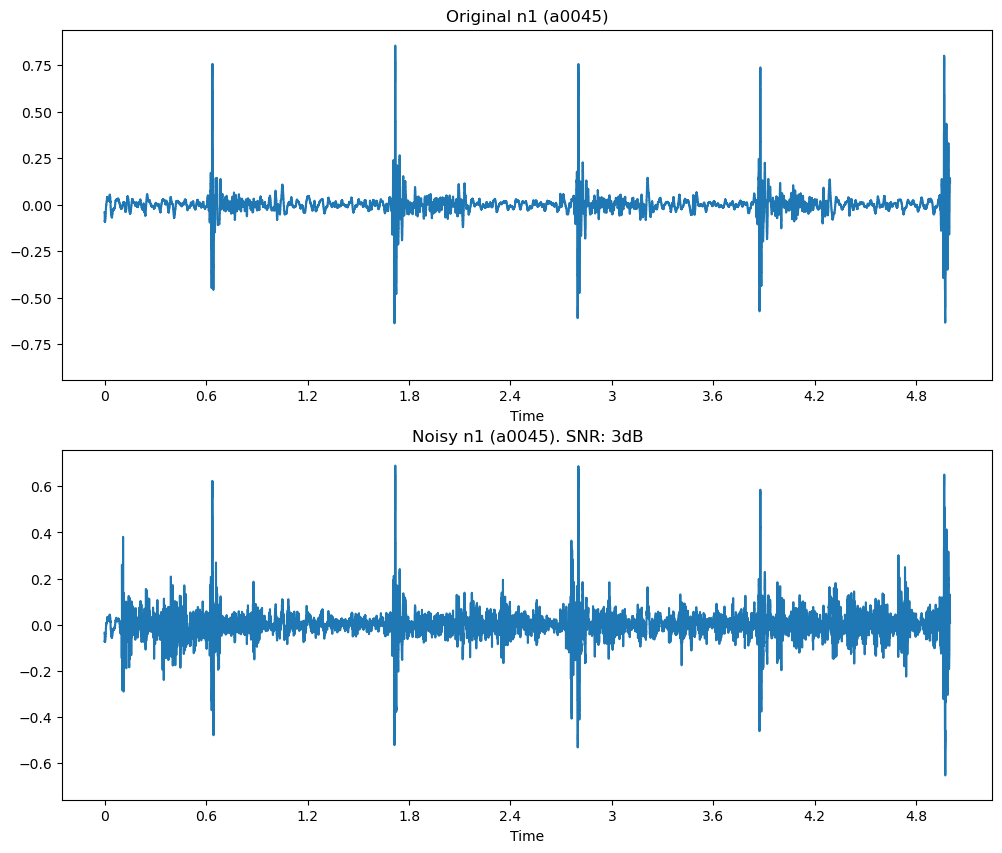

In [ ]:
# compare them
secs = 5
# plotting 
fig, ax = plt.subplots(nrows=2, figsize=(12, 5*2))
librosa.display.waveshow(normal_rec_1[:secs*sr_physio16],sr=sr_physio16,ax=ax[0])
ax[0].set(title='Original n1 (a0045)')
librosa.display.waveshow(noisy_n1[:secs*sr_physio16],sr=sr_physio16,ax=ax[1])
ax[1].set(title=f'Noisy n1 (a0045). SNR: {joint_snr}dB')

In [ ]:
# final steps: plot the model on these, then show results
model_denoised = []
segment_length = int(0.8 * sr_physio16) # seconds*sr (1600 samples here)
for noisy_rec in noisy_pcgs:
  cut_up_parts = []
  denoised_parts = []
  for i in range(0,len(noisy_rec)//segment_length):
      cut_up_parts.append(noisy_rec[i*segment_length:(i+1)*segment_length])
  with torch.no_grad():
    pseudo_unet.eval()
    for cut_up_part in cut_up_parts:
      cut_up_part = torch.tensor(cut_up_part, dtype=torch.float32)
      cut_up_part = cut_up_part.unsqueeze(0).unsqueeze(0).to(device) # expects (1,1,1600)
      denoised_part = pseudo_unet(cut_up_part)
      denoised_parts.append(denoised_part.cpu().detach().numpy()[0])
  model_denoised.append(np.concatenate(denoised_parts,axis=1)[0,:]) # remove the extra dimension
denoised_n1, denoised_n2, denoised_n3, denoised_m1, denoised_m2 = model_denoised

[Text(0.5, 1.0, 'Denoised n1 (a0045)')]

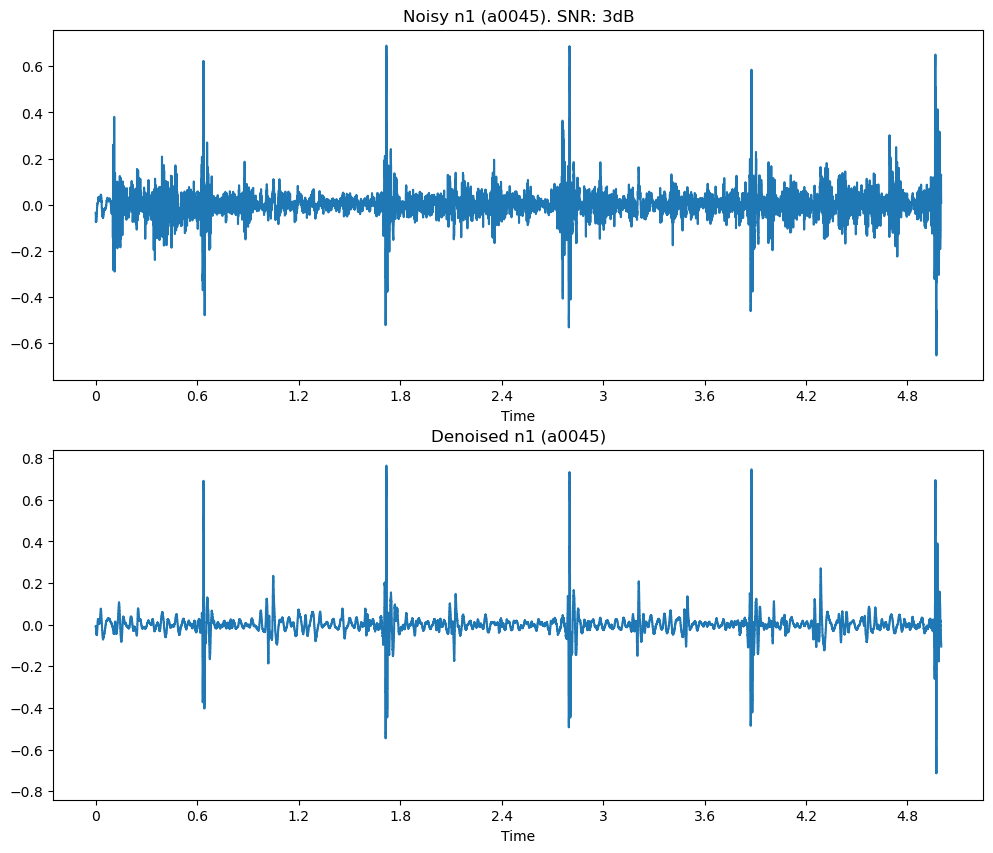

In [ ]:
# ok, this is the final product basically
fig, ax = plt.subplots(nrows=2, figsize=(12, 5*2))
librosa.display.waveshow(noisy_n1[:secs*sr_physio16],sr=sr_physio16,ax=ax[0])
ax[0].set(title=f'Noisy n1 (a0045). SNR: {joint_snr}dB')

librosa.display.waveshow(denoised_n1[:secs*sr_physio16],sr=sr_physio16,ax=ax[1])
ax[1].set(title=f'Denoised n1 (a0045)')

# wow this actually looks great

[Text(0.5, 1.0, 'Denoised n1 (a0045)')]

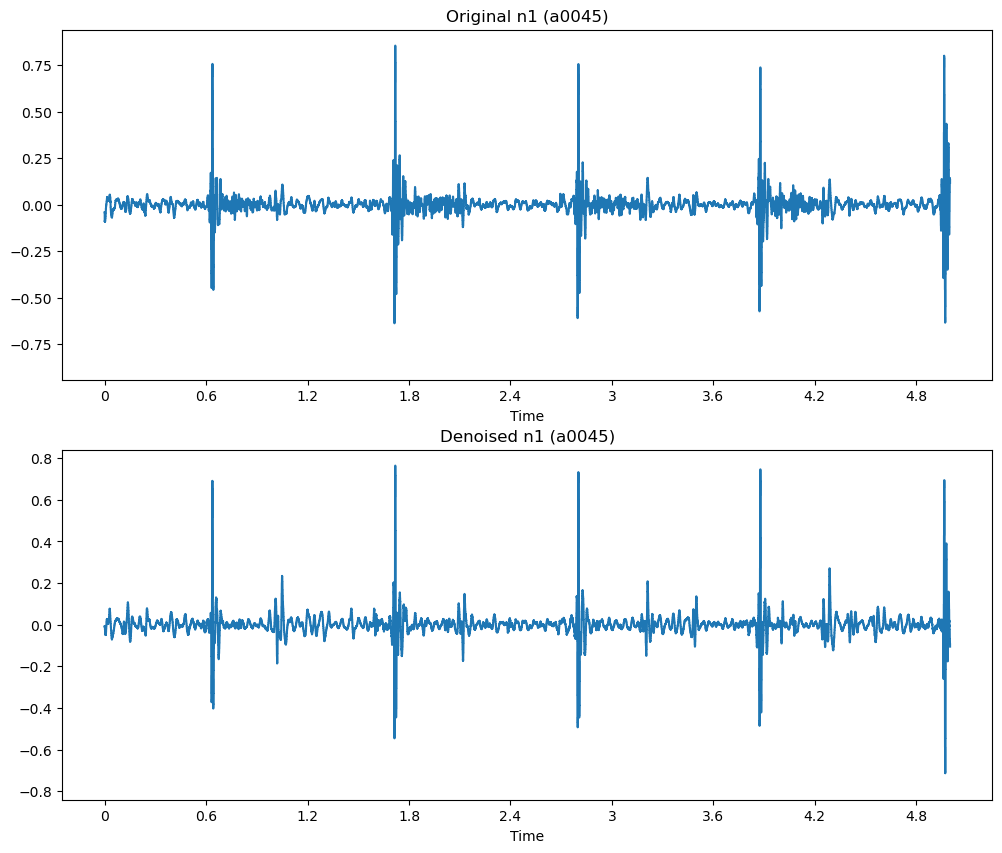

In [ ]:
# compare orig with denoised
fig, ax = plt.subplots(nrows=2, figsize=(12, 5*2))
librosa.display.waveshow(normal_rec_1[:secs*sr_physio16],sr=sr_physio16,ax=ax[0])
ax[0].set(title=f'Original n1 (a0045)')

librosa.display.waveshow(denoised_n1[:secs*sr_physio16],sr=sr_physio16,ax=ax[1])
ax[1].set(title=f'Denoised n1 (a0045)')

# wow this actually looks great

[Text(0.5, 1.0, 'Noisy m1 (b0197). SNR: 3dB')]

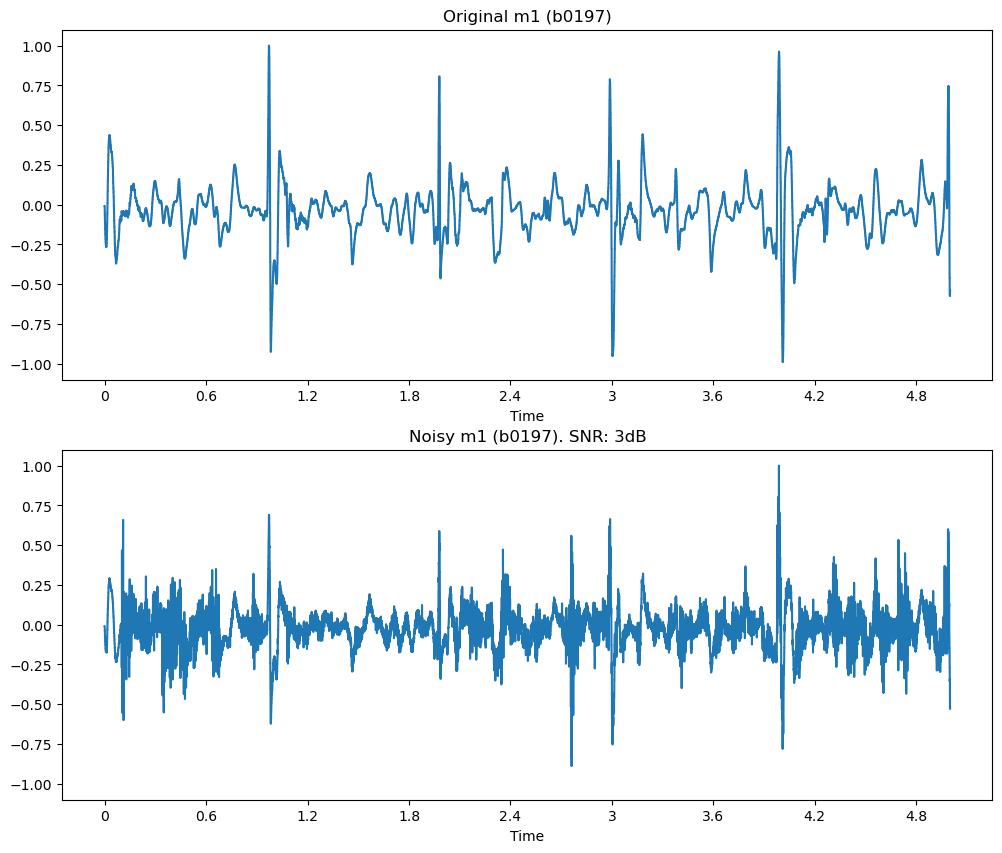

In [ ]:
# for murmurs
fig, ax = plt.subplots(nrows=2, figsize=(12, 5*2))
librosa.display.waveshow(murmur_rec_1[:secs*sr_physio16],sr=sr_physio16,ax=ax[0])
ax[0].set(title=f'Original m1 (b0197)')

librosa.display.waveshow(noisy_m1[:secs*sr_physio16],sr=sr_physio16,ax=ax[1])
ax[1].set(title=f'Noisy m1 (b0197). SNR: {joint_snr}dB')

[Text(0.5, 1.0, 'Denoised m1 (b0197)')]

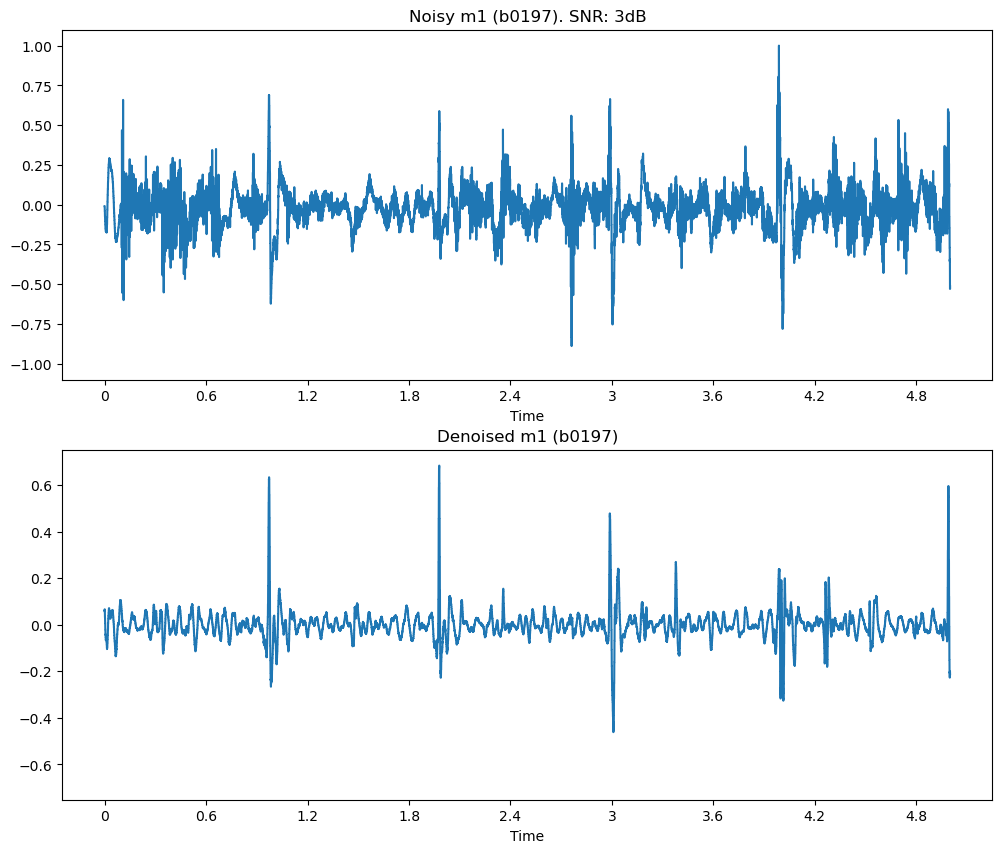

In [ ]:
# for murmur, noisy vs denoised
fig, ax = plt.subplots(nrows=2, figsize=(12, 5*2))
librosa.display.waveshow(noisy_m1[:secs*sr_physio16],sr=sr_physio16,ax=ax[0])
ax[0].set(title=f'Noisy m1 (b0197). SNR: {joint_snr}dB')

librosa.display.waveshow(denoised_m1[:secs*sr_physio16],sr=sr_physio16,ax=ax[1])
ax[1].set(title=f'Denoised m1 (b0197)')

[Text(0.5, 1.0, 'Denoised m1 (b0197)')]

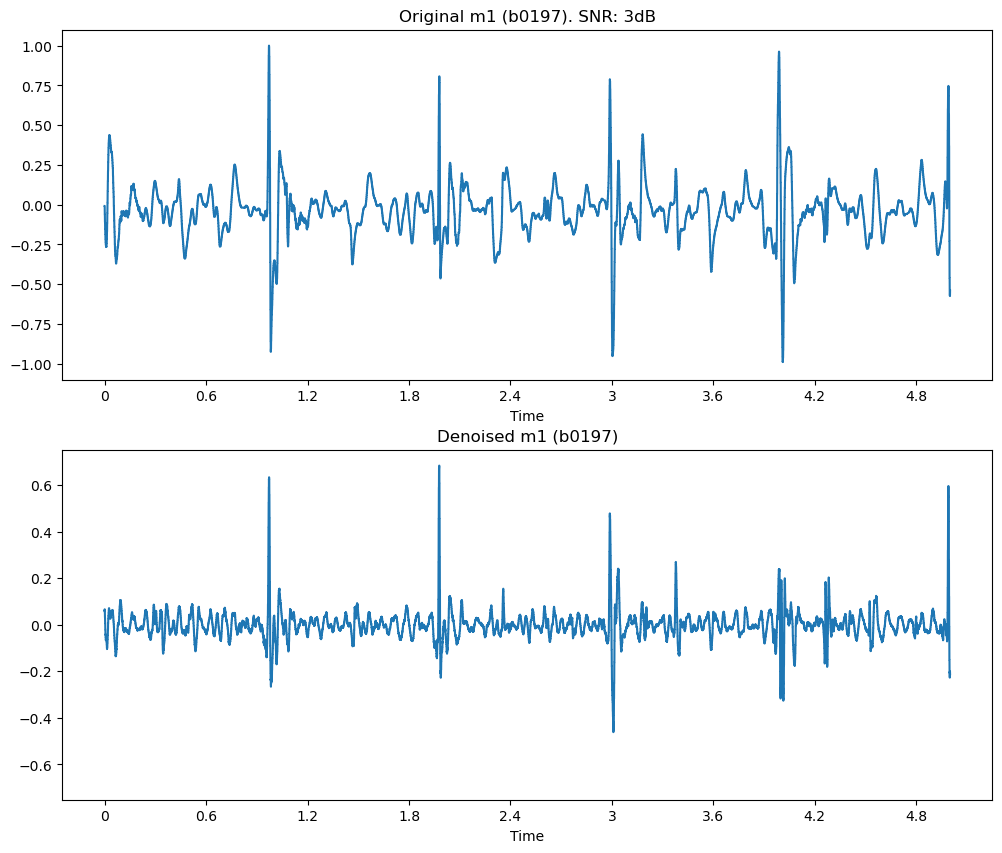

In [ ]:
# for murmur, original vs denoised
fig, ax = plt.subplots(nrows=2, figsize=(12, 5*2))
librosa.display.waveshow(murmur_rec_1[:secs*sr_physio16],sr=sr_physio16,ax=ax[0])
ax[0].set(title=f'Original m1 (b0197). SNR: {joint_snr}dB')


librosa.display.waveshow(denoised_m1[:secs*sr_physio16],sr=sr_physio16,ax=ax[1])
ax[1].set(title=f'Denoised m1 (b0197)')

## 9. Appendix

In [ ]:
# amount of parameters in the model
total_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {total_params}")

Model parameters: 985601
